In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)

# scaling data to range 0-1
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# set path for data directories
train_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/train"
test_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/test"

# Import data and turn into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                                batch_size = 32, # size of mini batches
                                                target_size=(224, 224), # size of output image
                                                class_mode = "categorical", # type of data
                                                seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                                batch_size = 32,
                                                target_size=(224, 224),
                                                class_mode = "categorical",
                                                seed = 42)

Found 2500 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


In [3]:
# seting callbacks 
# Tracking experiment with TensorBoard
# model checkpoint ModelCheckpoint
# EarlyStoping

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(lod_dir = log_dir)
    print(f"Saving TensorBoard log file to: {log_dir}")
    return tensorboard_callback

In [22]:
# create machine learning model with transfer learning
import tensorflow_hub as hub

IMAGE_SHAPE = (224, 224)

def create_model(model_url, num_classes = 10):
    feature_extracion_layer = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
    
    model = tf.keras.Sequential([
        feature_extracion_layer,
        tf.keras.layers.Dense(num_classes,activation='softmax')
    ])
    return model

model = create_model("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")

In [24]:
#model.summary()
# compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ["accuracy"])
#fit
history = model.fit(train_data, #Image data generator crate sample with labels
                        epochs=4,
                        steps_per_epoch=len(train_data), # train_data/batches = 47
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/4
79/79 [==============================] - 236s 3s/step - loss: 2.2816 - accuracy: 0.3036 - val_loss: 2.2587 - val_accuracy: 0.4387
Epoch 2/4
79/79 [==============================] - 226s 3s/step - loss: 2.2327 - accuracy: 0.5452 - val_loss: 2.2138 - val_accuracy: 0.5707
Epoch 3/4
79/79 [==============================] - 228s 3s/step - loss: 2.1845 - accuracy: 0.6200 - val_loss: 2.1706 - val_accuracy: 0.6120
Epoch 4/4
79/79 [==============================] - 256s 3s/step - loss: 2.1380 - accuracy: 0.6544 - val_loss: 2.1281 - val_accuracy: 0.6320


[[0.09591334 0.09565404 0.09486558 0.08739086 0.09482632 0.08753717
  0.16666907 0.09766698 0.09245951 0.08701716]]


Text(0.5, 1.0, 'Prediction is: pizza')

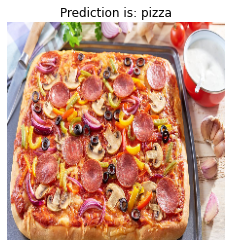

In [31]:
import matplotlib.image as mpimg
import random
import pathlib

data_dir = pathlib.Path("/Users/korzeniewski/Downloads/10_food_classes_all_data/test")
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))

def load_and_prep_image(path, img_shape=224):
    img = mpimg.imread(path)
    img = tf.constant(img)
    img = tf.image.resize(img, size= [img_shape, img_shape])
    img = img/255
    return img

img=load_and_prep_image(path = '/Users/korzeniewski/Downloads/pizza-rodzinna.jpg')

pred = model.predict(tf.expand_dims(img, axis = 0))
print(pred)
plt.imshow(img)
plt.axis(False)
plt.title("Prediction is: " + class_names[pred.argmax()])

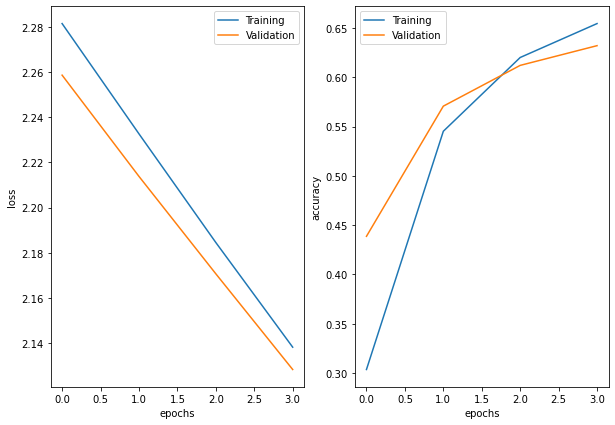

In [32]:
# evaluate model
pd.DataFrame(history.history)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(len(val_acc))

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["Training", "Validation"])